In [13]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [14]:
data_path = "../data/BPI_Challenge_2017.gzip"

# Event of interest: what to predict
event_of_interest = "A_Cancelled"  # O_Accepted

df_bpi= pd.read_parquet("../data/BPI_Challenge_2017.gzip")
df_bpi.rename(inplace=True, columns={"time:timestamp": "time", "case:concept:name": "case", "concept:name": "event"})
df_bpi["time"] = pd.to_datetime(df_bpi["time"], errors='coerce')

# Filtering on end events

In [3]:
# Group data by case_id and get start and end events
start_events = df_bpi.groupby('case')['event'].first()
end_events = df_bpi.groupby('case')['event'].last()

# Count occurrences of start and end events
start_event_counts = Counter(start_events)
end_event_counts = Counter(end_events)

# Combine results into a DataFrame
results = pd.DataFrame({
    'Start_Event_Count': pd.Series(start_event_counts),
    'End_Event_Count': pd.Series(end_event_counts)
}).fillna(0).astype(int)

# Display the results
print(results)
# We conclude that only O_Cancelled, W_Call after offers, W_Call incomplete files, W_validate_application
# Remove other traces makes the process more uniform. 

# This is what is done in the "filter_log" function below

                            Start_Event_Count  End_Event_Count
A_Create Application                    31509                0
A_Denied                                    0                1
O_Cancelled                                 0             4436
O_Returned                                  0                1
O_Sent (mail and online)                    0               15
O_Sent (online only)                        0                8
W_Assess potential fraud                    0              102
W_Call after offers                         0             9457
W_Call incomplete files                     0             4676
W_Complete application                      0              144
W_Personal Loan collection                  0                2
W_Shortened completion                      0                5
W_Validate application                      0            12662


# Bucketing starting sequences

Dictionary of Starting Sequences (Length 5) with Frequencies > 0:
{('A_Create Application', 'A_Submitted', 'W_Handle leads', 'W_Handle leads', 'W_Complete application'): 16780, ('A_Create Application', 'W_Complete application', 'W_Complete application', 'A_Concept', 'A_Accepted'): 7235, ('A_Create Application', 'A_Submitted', 'W_Handle leads', 'W_Handle leads', 'W_Handle leads'): 3621, ('A_Create Application', 'W_Complete application', 'W_Complete application', 'A_Concept', 'W_Complete application'): 462, ('A_Create Application', 'A_Concept', 'W_Complete application', 'W_Complete application', 'W_Complete application'): 1850, ('A_Create Application', 'A_Concept', 'W_Complete application', 'W_Complete application', 'A_Accepted'): 1539, ('A_Create Application', 'A_Submitted', 'W_Handle leads', 'W_Handle leads', 'W_Assess potential fraud'): 22}


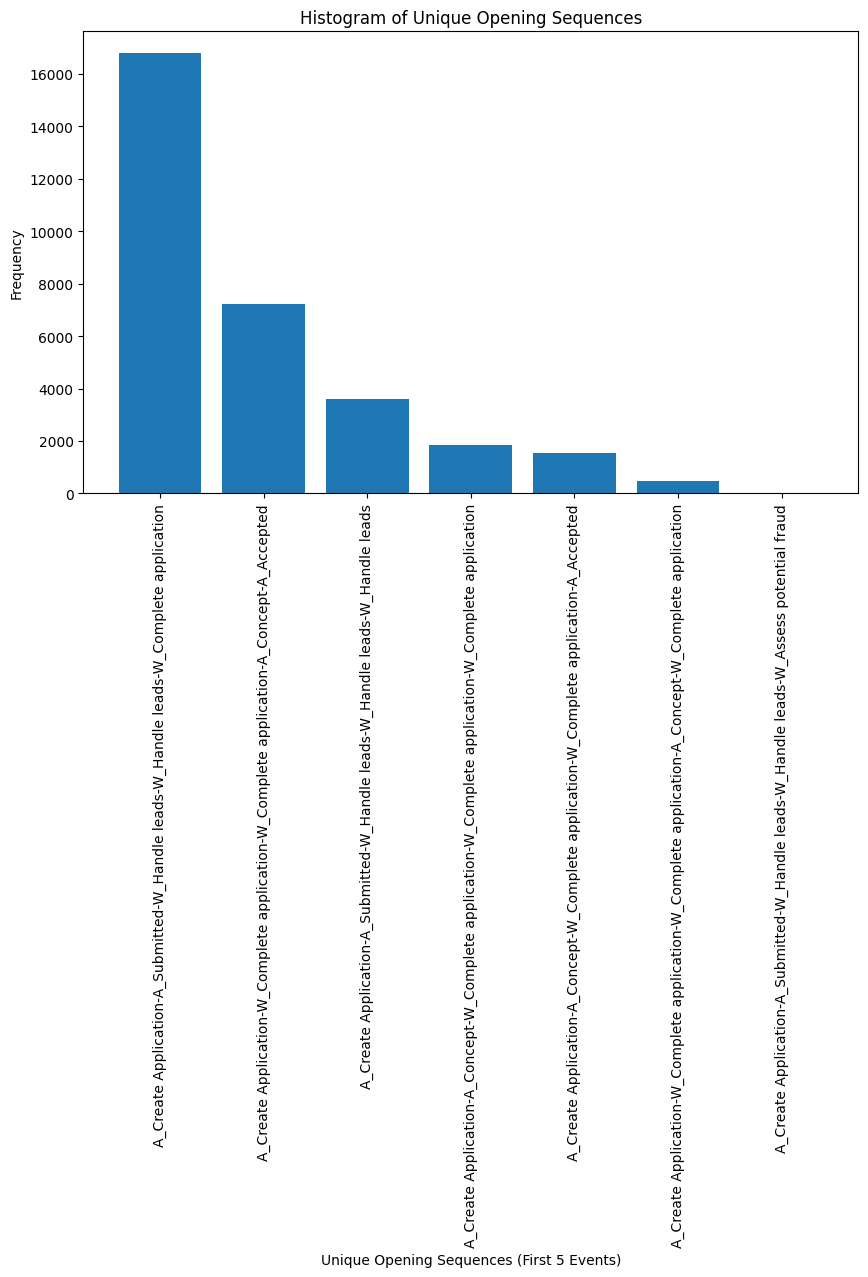

In [6]:
# Step 1: Group events by case_id
grouped = df_bpi.groupby('case')['event'].apply(list)

# Step 2: Extract the first 5 events
sequences = grouped.apply(lambda x: tuple(x[:5]) if len(x) >= 5 else None).dropna()

# Step 3: Count unique sequences
sequence_counts = Counter(sequences)

# Step 4: Filter sequences with frequency > 0 (all valid counts)
filtered_sequences = {seq: count for seq, count in sequence_counts.items() if count > 0}

# Step 5: Print results
print("Dictionary of Starting Sequences (Length 5) with Frequencies > 0:")
print(filtered_sequences)

# Step 6: Convert Counter to DataFrame for visualization
hist_data = pd.DataFrame(sequence_counts.items(), columns=['Sequence', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Step 5: Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(['-'.join(seq) for seq in hist_data['Sequence']], hist_data['Frequency'])
plt.xticks(rotation=90)
plt.xlabel('Unique Opening Sequences (First 5 Events)')
plt.ylabel('Frequency')
plt.title('Histogram of Unique Opening Sequences')
plt.show()

# Looking into other columns

In [26]:
df_bpi.columns

Index(['Action', 'org:resource', 'event', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time', 'case:LoanGoal', 'case:ApplicationType',
       'case', 'case:RequestedAmount', 'FirstWithdrawalAmount',
       'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected', 'CreditScore',
       'OfferedAmount', 'OfferID'],
      dtype='object')

In [39]:
df_bpi[~df_bpi.Selected.isna()].NumberOfTerms

9           44.0
50          33.0
79         120.0
87         120.0
135         96.0
           ...  
1202122    120.0
1202124    127.0
1202148    120.0
1202202     77.0
1202254     77.0
Name: NumberOfTerms, Length: 42995, dtype: float64

In [30]:
df_bpi

,Action,org:resource,event,EventOrigin,EventID,lifecycle:transition,time,case:LoanGoal,case:ApplicationType,case,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1202263,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,2017-01-06 06:33:02.221000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1202264,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1202265,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,2017-01-16 09:51:21.139000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,Offer_1580299144


In [29]:
df_bpi["case:RequestedAmount"]

0          20000.0
1          20000.0
2          20000.0
3          20000.0
4          20000.0
            ...   
1202262    20000.0
1202263    20000.0
1202264    20000.0
1202265    20000.0
1202266    20000.0
Name: case:RequestedAmount, Length: 1202267, dtype: float64

In [31]:
df_bpi["case:ApplicationType"]

0          New credit
1          New credit
2          New credit
3          New credit
4          New credit
              ...    
1202262    New credit
1202263    New credit
1202264    New credit
1202265    New credit
1202266    New credit
Name: case:ApplicationType, Length: 1202267, dtype: object

In [ ]:
df_bpi["case:LoanGoal"]

0          Existing loan takeover
1          Existing loan takeover
2          Existing loan takeover
3          Existing loan takeover
4          Existing loan takeover
                    ...          
1202262          Home improvement
1202263          Home improvement
1202264          Home improvement
1202265          Home improvement
1202266          Home improvement
Name: case:LoanGoal, Length: 1202267, dtype: object

In [28]:
print(df_bpi[~df_bpi["case:RequestedAmount"].isna()])
df_bpi[~df_bpi["case:RequestedAmount"].isna()].event.unique()

              Action org:resource                   event  EventOrigin  \
0            Created       User_1    A_Create Application  Application   
1        statechange       User_1             A_Submitted  Application   
2            Created       User_1          W_Handle leads     Workflow   
3            Deleted       User_1          W_Handle leads     Workflow   
4            Created       User_1  W_Complete application     Workflow   
...              ...          ...                     ...          ...   
1202262      Deleted       User_1     W_Call after offers     Workflow   
1202263      Created       User_1     W_Call after offers     Workflow   
1202264  statechange      User_28             A_Cancelled  Application   
1202265  statechange      User_28             O_Cancelled        Offer   
1202266      Deleted      User_28     W_Call after offers     Workflow   

                       EventID lifecycle:transition  \
0        Application_652823628             complete   
1

array(['A_Create Application', 'A_Submitted', 'W_Handle leads',
       'W_Complete application', 'A_Concept', 'A_Accepted',
       'O_Create Offer', 'O_Created', 'O_Sent (mail and online)',
       'W_Call after offers', 'A_Complete', 'W_Validate application',
       'A_Validating', 'O_Returned', 'W_Call incomplete files',
       'A_Incomplete', 'O_Accepted', 'A_Pending', 'A_Denied', 'O_Refused',
       'O_Cancelled', 'A_Cancelled', 'O_Sent (online only)',
       'W_Assess potential fraud', 'W_Personal Loan collection',
       'W_Shortened completion '], dtype=object)

In [25]:
print(df_bpi[~df_bpi.CreditScore.isna()])
df_bpi[~df_bpi.CreditScore.isna()].event.unique()

          Action org:resource           event EventOrigin           EventID  \
9        Created      User_52  O_Create Offer       Offer   Offer_148581083   
50       Created      User_38  O_Create Offer       Offer  Offer_1669071500   
79       Created      User_19  O_Create Offer       Offer  Offer_1209840642   
87       Created      User_19  O_Create Offer       Offer   Offer_997411923   
135      Created      User_19  O_Create Offer       Offer  Offer_1319158006   
...          ...          ...             ...         ...               ...   
1202122  Created      User_84  O_Create Offer       Offer   Offer_682062790   
1202124  Created      User_84  O_Create Offer       Offer  Offer_1395096354   
1202148  Created      User_84  O_Create Offer       Offer  Offer_1445809476   
1202202  Created      User_84  O_Create Offer       Offer  Offer_1734870628   
1202254  Created      User_96  O_Create Offer       Offer  Offer_1580299144   

        lifecycle:transition                       

array(['O_Create Offer'], dtype=object)

In [27]:
print(df_bpi[~df_bpi.MonthlyCost.isna()])
df_bpi[~df_bpi.MonthlyCost.isna()].event.unique()

          Action org:resource           event EventOrigin           EventID  \
9        Created      User_52  O_Create Offer       Offer   Offer_148581083   
50       Created      User_38  O_Create Offer       Offer  Offer_1669071500   
79       Created      User_19  O_Create Offer       Offer  Offer_1209840642   
87       Created      User_19  O_Create Offer       Offer   Offer_997411923   
135      Created      User_19  O_Create Offer       Offer  Offer_1319158006   
...          ...          ...             ...         ...               ...   
1202122  Created      User_84  O_Create Offer       Offer   Offer_682062790   
1202124  Created      User_84  O_Create Offer       Offer  Offer_1395096354   
1202148  Created      User_84  O_Create Offer       Offer  Offer_1445809476   
1202202  Created      User_84  O_Create Offer       Offer  Offer_1734870628   
1202254  Created      User_96  O_Create Offer       Offer  Offer_1580299144   

        lifecycle:transition                       

array(['O_Create Offer'], dtype=object)

In [ ]:
# case:loangoal
# case:requestedamount
# life

In [19]:
df_bpi.MonthlyCost.dropna()

9          498.29
50         200.00
79         158.98
87         158.98
135        198.65
            ...  
1202122    154.11
1202124    150.00
1202148    106.46
1202202    450.00
1202254    297.81
Name: MonthlyCost, Length: 42995, dtype: float64

In [12]:
df_bpi.columns

Index(['Action', 'org:resource', 'event', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time', 'case:LoanGoal', 'case:ApplicationType',
       'case', 'case:RequestedAmount', 'FirstWithdrawalAmount',
       'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected', 'CreditScore',
       'OfferedAmount', 'OfferID'],
      dtype='object')

In [15]:
df_bpi.EventOrigin.unique()

array(['Application', 'Workflow', 'Offer'], dtype=object)

In [17]:
df_bpi["case:RequestedAmount"]

0          20000.0
1          20000.0
2          20000.0
3          20000.0
4          20000.0
            ...   
1202262    20000.0
1202263    20000.0
1202264    20000.0
1202265    20000.0
1202266    20000.0
Name: case:RequestedAmount, Length: 1202267, dtype: float64

In [16]:
df_bpi["case:LoanGoal"]

0          Existing loan takeover
1          Existing loan takeover
2          Existing loan takeover
3          Existing loan takeover
4          Existing loan takeover
                    ...          
1202262          Home improvement
1202263          Home improvement
1202264          Home improvement
1202265          Home improvement
1202266          Home improvement
Name: case:LoanGoal, Length: 1202267, dtype: object

In [ ]:
# Bucket pre-offer model afgeleid door alle waardes die we nog niet weten
# Bucket post-offer model kan gebruik maken van alle laatste offer details
#    Want veel interessante info onder de "offer_created" event
#    Functie schrijven om deze info van nieuwste offer mee te nemen in opvolgende prefixes

# O_Create Offer Bucketing:

In [4]:
df = df_bpi.copy()
# Add a natural event order index within each case
df['event_index'] = df.groupby('case').cumcount()

# Filter to find 'O_Create Offer' and retrieve its event_index
o_create_offer_indices = df[df['event'] == 'O_Create Offer'][['case', 'event_index']]

# Display the results
print(o_create_offer_indices)

                           case  event_index
9         Application_652823628            9
50       Application_1691306052           10
79        Application_428409768            8
87        Application_428409768           16
135      Application_1746793196           19
...                         ...          ...
1202122  Application_2103458006            9
1202124  Application_2103458006           11
1202148    Application_59622033           12
1202202   Application_303923658            9
1202254  Application_1350494635            8

[42995 rows x 2 columns]


In [5]:
o_create_offer_indices.event_index.mean()

np.float64(12.113501569949994)

# Evidence for specific threshold trace length

     case_length  A_Cancelled_Probability
0             10                 0.166667
1             11                 0.200000
2             12                 0.555556
3             13                 0.333333
4             14                 0.133333
..           ...                      ...
132          150                 0.000000
133          154                 0.000000
134          156                 0.000000
135          159                 0.000000
136          180                 0.000000

[137 rows x 2 columns]


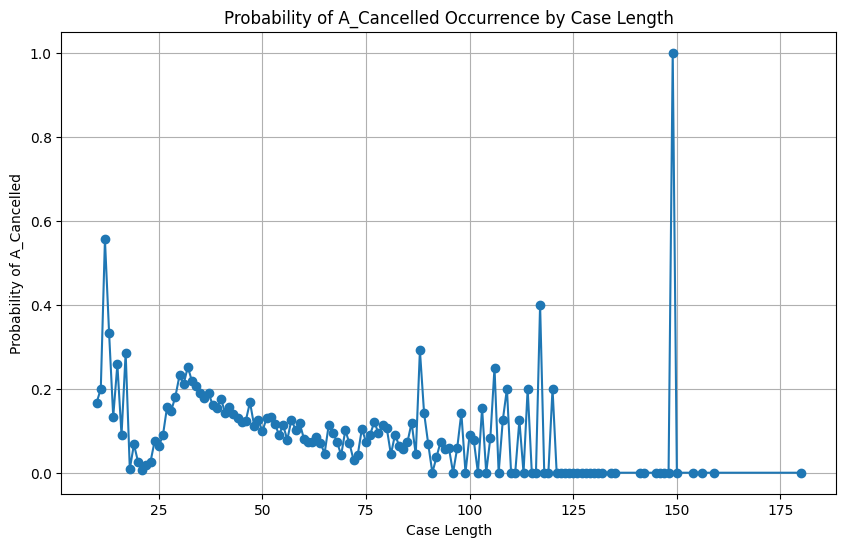

In [12]:
import pandas as pd

# Example: Load the dataset (replace with your file path)
# df = pd.read_csv("your_file.csv")

# Ensure the dataframe has 'case_id' and 'event_name' columns
# Step 1: Calculate case length for each case_id
case_lengths = df_bpi.groupby('case').size().reset_index(name='case_length')

# Step 2: Check if 'A_Cancelled' occurred in each case
a_cancelled_cases = df_bpi[df_bpi['event'] == 'A_Denied'].groupby('case').size().reset_index(name='a_cancelled')

# Step 3: Merge the case lengths and A_Cancelled indicator
case_summary = case_lengths.merge(a_cancelled_cases[['case']], on='case', how='left')
case_summary['A_Cancelled'] = case_summary['case'].isin(a_cancelled_cases['case']).astype(int)

# Step 4: Group by case length and calculate the probability of A_Cancelled
result = case_summary.groupby('case_length')['A_Cancelled'].mean().reset_index(name='A_Cancelled_Probability')

# Step 5: Display the results
print(result)

# Optional: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(result['case_length'], result['A_Cancelled_Probability'], marker='o')
plt.title("Probability of A_Cancelled Occurrence by Case Length")
plt.xlabel("Case Length")
plt.ylabel("Probability of A_Cancelled")
plt.grid()
plt.show()

In [10]:
df_bpi.event.unique()

array(['A_Create Application', 'A_Submitted', 'W_Handle leads',
       'W_Complete application', 'A_Concept', 'A_Accepted',
       'O_Create Offer', 'O_Created', 'O_Sent (mail and online)',
       'W_Call after offers', 'A_Complete', 'W_Validate application',
       'A_Validating', 'O_Returned', 'W_Call incomplete files',
       'A_Incomplete', 'O_Accepted', 'A_Pending', 'A_Denied', 'O_Refused',
       'O_Cancelled', 'A_Cancelled', 'O_Sent (online only)',
       'W_Assess potential fraud', 'W_Personal Loan collection',
       'W_Shortened completion '], dtype=object)

In [18]:
df_bpi[df_bpi["event"] == "W_Call after offers"].nunique()

Action                        4
org:resource                144
event                         1
EventOrigin                   1
EventID                  191092
lifecycle:transition          7
time                     191084
case:LoanGoal                14
case:ApplicationType          2
case                      31362
case:RequestedAmount        699
FirstWithdrawalAmount         0
NumberOfTerms                 0
Accepted                      0
MonthlyCost                   0
Selected                      0
CreditScore                   0
OfferedAmount                 0
OfferID                       0
dtype: int64

In [20]:
df_bpi.groupby("case").cumcount()

0           0
1           1
2           2
3           3
4           4
           ..
1202262    16
1202263    17
1202264    18
1202265    19
1202266    20
Length: 1202267, dtype: int64

In [25]:
# Step 1: Filter rows where Event == 'W_Call after affairs' and Lifecycle == 'start'
filtered_df = df_bpi[(df_bpi['event'] == 'W_Call after offers') & (df_bpi['lifecycle:transition'] == 'start')]

# Step 2: Count the occurrences for each Case
start_counts = filtered_df.groupby('case').size().reset_index(name='Start_Count')

In [28]:
start_counts[start_counts.Start_Count == 3]

,case,Start_Count
902,Application_1057390418,3
7269,Application_1442859871,3
10487,Application_1644818467,3
11947,Application_1734458355,3
13549,Application_1830575003,3
14770,Application_1908110751,3
30726,Application_958762299,3


In [32]:
filtered_df = df_bpi[(df_bpi.case == "Application_1057390418") & (df_bpi['event'] == 'W_Call after offers')]

In [33]:
filtered_df

,Action,org:resource,event,EventOrigin,EventID,lifecycle:transition,time,case:LoanGoal,case:ApplicationType,case,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
250064,Created,User_23,W_Call after offers,Workflow,Workitem_1960461961,schedule,2016-03-24 12:07:16.429000+00:00,"Other, see explanation",New credit,Application_1057390418,27000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
250065,Obtained,User_23,W_Call after offers,Workflow,Workitem_257878120,start,2016-03-24 12:07:16.433000+00:00,"Other, see explanation",New credit,Application_1057390418,27000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
250067,Released,User_23,W_Call after offers,Workflow,Workitem_833975094,suspend,2016-03-24 12:10:06.879000+00:00,"Other, see explanation",New credit,Application_1057390418,27000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
250068,Obtained,User_24,W_Call after offers,Workflow,Workitem_907510673,resume,2016-03-28 13:02:06.062000+00:00,"Other, see explanation",New credit,Application_1057390418,27000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
250069,Released,User_24,W_Call after offers,Workflow,Workitem_468115474,suspend,2016-03-28 13:02:29.151000+00:00,"Other, see explanation",New credit,Application_1057390418,27000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
250070,Deleted,User_144,W_Call after offers,Workflow,Workitem_1417139672,ate_abort,2016-04-19 07:45:42.248000+00:00,"Other, see explanation",New credit,Application_1057390418,27000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
250071,Created,User_144,W_Call after offers,Workflow,Workitem_1235814949,schedule,2016-04-19 07:45:42.287000+00:00,"Other, see explanation",New credit,Application_1057390418,27000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
250072,Obtained,User_144,W_Call after offers,Workflow,Workitem_169343386,start,2016-04-19 07:45:42.289000+00:00,"Other, see explanation",New credit,Application_1057390418,27000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
250073,Released,User_144,W_Call after offers,Workflow,Workitem_80968754,suspend,2016-04-19 07:45:51.522000+00:00,"Other, see explanation",New credit,Application_1057390418,27000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
250074,Deleted,User_119,W_Call after offers,Workflow,Workitem_1959335378,ate_abort,2016-04-19 07:46:29.578000+00:00,"Other, see explanation",New credit,Application_1057390418,27000.0,NaN,NaN,None,NaN,None,NaN,NaN,None


In [78]:
df_bpi

,Action,org:resource,event,EventOrigin,EventID,lifecycle:transition,time,case:LoanGoal,case:ApplicationType,case,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,loan_diff_req_and_off
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None,NaN
1202263,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,2017-01-06 06:33:02.221000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None,NaN
1202264,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None,NaN
1202265,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,2017-01-16 09:51:21.139000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,Offer_1580299144,NaN


In [96]:
import numpy as np

# Calculate the percentage difference, handling division by zero
df_bpi["loan_diff_req_and_off_perc"] = np.where(
    df_bpi["case:RequestedAmount"] != 0,
    (df_bpi["OfferedAmount"] - df_bpi["case:RequestedAmount"]) / df_bpi["case:RequestedAmount"],
    0
)
# If 0 requested, than difference is 0 because no values entered
df_bpi["loan_diff_req_and_off_perc"].unique()

array([        nan,  0.        , -0.4       , ...,  0.43666667,
        0.00263158,  0.06481481])

In [34]:
df_bpi["loan_diff_req_and_off"] = df_bpi["OfferedAmount"] - df_bpi["case:RequestedAmount"]
df_bpi["loan_diff_req_and_off"]

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
1202262   NaN
1202263   NaN
1202264   NaN
1202265   NaN
1202266   NaN
Name: loan_diff_req_and_off, Length: 1202267, dtype: float64

In [36]:
df_bpi[df_bpi.event == "O_Create Offer"].loan_diff_req_and_off.unique()

array([ 0.00000e+00, -4.00000e+03,  1.07000e+04,  4.00000e+03,
        5.00000e+01, -8.00000e+03,  8.00000e+03, -2.00000e+03,
        3.00000e+03,  4.20000e+03, -1.00000e+03,  2.70000e+04,
        3.40000e+03,  1.00000e+04,  2.00000e+03,  1.75000e+04,
       -5.00000e+03,  5.00000e+02,  2.30000e+04,  7.00000e+03,
        5.00000e+03,  1.15000e+04,  1.10000e+03, -5.00000e+02,
       -3.75000e+03, -1.00000e+04,  6.00000e+02,  1.00000e+03,
       -3.00000e+03,  6.80000e+03,  2.36000e+04,  2.50000e+04,
        2.40000e+03,  2.68000e+04,  2.40000e+04,  2.00000e+04,
       -1.20000e+03,  6.00000e+03, -1.80000e+03,  5.10000e+03,
        2.50000e+03,  2.31000e+04,  1.50000e+04,  1.25000e+04,
        1.75000e+03,  2.00000e+02,  1.50000e+03,  1.00000e+02,
        1.40000e+01,  5.31400e+03, -1.00000e+02, -5.10000e+03,
        7.00000e+02, -7.50000e+03,  2.25000e+04,  1.79000e+04,
        3.10000e+04,  4.70000e+03, -1.05000e+04, -7.00000e+03,
       -2.50000e+03, -6.50000e+02, -1.35000e+04,  3.500

In [97]:
from tqdm import tqdm

df = df_bpi.copy()
df['prefix'] = None
df['total_time_prefix'] = None

grouped = df.groupby('case')

# Add a progress bar to show progress through the cases
for case_id, group in tqdm(grouped, desc="Creating prefixes", total=len(grouped)):
    prefix_list = []
    first_time = None
    for idx, row in group.iterrows():
        prefix_list.append(row['event'])
        if first_time is None:
            first_time = row['time']
        total_seconds = (row['time'] - first_time).total_seconds()
        df.at[idx, 'prefix'] = prefix_list.copy()
        df.at[idx, 'total_time_prefix'] = total_seconds

# Convert prefixes to lists (if necessary)
df['prefix'] = df['prefix'].apply(lambda x: list(x) if isinstance(x, list) else x)

# Optional: Drop last row as per original code
df = df[:-1]

df = df.copy()
print("Computing prefix lengths and case traces...")

df['prefix_length'] = df['prefix'].apply(len)
case_traces = df.groupby('case')['event'].apply(list)
df['case_trace'] = df['case'].map(case_traces)

print("Checking for A_Cancelled occurrences...")
df['event_of_interest_is_in_prefix'] = df['prefix'].apply(lambda x: x.count(event_of_interest))
df['event_of_interest_occured'] = df['case_trace'].apply(lambda x: x.count(event_of_interest))
df = df[(df['event_of_interest_is_in_prefix'] != 1)] # Remove rows where A_Cancelled has already happened


Creating prefixes: 100%|██████████| 31509/31509 [02:00<00:00, 261.90it/s]


Computing prefix lengths and case traces...
Checking for A_Cancelled occurrences...


In [98]:
# Filter for the event of interest
df_create_offer = df[df['event'] == "O_Create Offer"]

# Method 1: Using groupby and idxmax
last_offer_idx = df_create_offer.groupby('case')['time'].idxmax()
df_last_create_offer = df_create_offer.loc[last_offer_idx].reset_index(drop=True)
df_last_create_offer

,Action,org:resource,event,EventOrigin,EventID,lifecycle:transition,time,case:LoanGoal,case:ApplicationType,case,...,OfferedAmount,OfferID,loan_diff_req_and_off,loan_diff_req_and_off_perc,prefix,total_time_prefix,prefix_length,case_trace,event_of_interest_is_in_prefix,event_of_interest_occured
0,Created,User_5,O_Create Offer,Offer,Offer_410892064,complete,2016-08-05 13:59:57.320000+00:00,"Other, see explanation",New credit,Application_1000086665,...,5000.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",165755.647,10,"[A_Create Application, A_Submitted, W_Handle l...",0,1
1,Created,User_32,O_Create Offer,Offer,Offer_927137349,complete,2016-06-06 08:12:02.402000+00:00,Home improvement,New credit,Application_1000158214,...,12500.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",338255.558,9,"[A_Create Application, A_Submitted, W_Handle l...",0,0
2,Created,User_71,O_Create Offer,Offer,Offer_2032690166,complete,2016-04-04 16:12:03.476000+00:00,Car,New credit,Application_1000311556,...,45000.0,None,0.0,0.0,"[A_Create Application, W_Complete application,...",925.801,6,"[A_Create Application, W_Complete application,...",0,1
3,Created,User_91,O_Create Offer,Offer,Offer_2062524462,complete,2016-09-16 11:35:15.403000+00:00,"Other, see explanation",New credit,Application_1000334415,...,5000.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",68157.645,11,"[A_Create Application, A_Submitted, W_Handle l...",0,0
4,Created,User_28,O_Create Offer,Offer,Offer_542912001,complete,2016-03-18 08:30:18.800000+00:00,Existing loan takeover,New credit,Application_1000339879,...,37500.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",70388.641,9,"[A_Create Application, A_Submitted, W_Handle l...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31504,Created,User_16,O_Create Offer,Offer,Offer_268415266,complete,2016-03-17 17:33:16.217000+00:00,Not speficied,New credit,Application_999507989,...,24000.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",38379.425,10,"[A_Create Application, A_Submitted, W_Handle l...",0,0
31505,Created,User_19,O_Create Offer,Offer,Offer_610539704,complete,2016-06-27 08:42:41.810000+00:00,Car,New credit,Application_999544538,...,50000.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",4395358.896,48,"[A_Create Application, A_Submitted, W_Handle l...",0,0
31506,Created,User_94,O_Create Offer,Offer,Offer_872978767,complete,2016-12-16 10:17:22.809000+00:00,Existing loan takeover,New credit,Application_999632431,...,12000.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",78746.662,11,"[A_Create Application, A_Submitted, W_Handle l...",0,1
31507,Created,User_15,O_Create Offer,Offer,Offer_148382244,complete,2016-07-07 15:32:11.395000+00:00,Home improvement,Limit raise,Application_999993467,...,15000.0,None,5000.0,0.5,"[A_Create Application, A_Concept, W_Complete a...",169869.027,16,"[A_Create Application, A_Concept, W_Complete a...",0,0


In [99]:
df_last_create_offer

,Action,org:resource,event,EventOrigin,EventID,lifecycle:transition,time,case:LoanGoal,case:ApplicationType,case,...,OfferedAmount,OfferID,loan_diff_req_and_off,loan_diff_req_and_off_perc,prefix,total_time_prefix,prefix_length,case_trace,event_of_interest_is_in_prefix,event_of_interest_occured
0,Created,User_5,O_Create Offer,Offer,Offer_410892064,complete,2016-08-05 13:59:57.320000+00:00,"Other, see explanation",New credit,Application_1000086665,...,5000.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",165755.647,10,"[A_Create Application, A_Submitted, W_Handle l...",0,1
1,Created,User_32,O_Create Offer,Offer,Offer_927137349,complete,2016-06-06 08:12:02.402000+00:00,Home improvement,New credit,Application_1000158214,...,12500.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",338255.558,9,"[A_Create Application, A_Submitted, W_Handle l...",0,0
2,Created,User_71,O_Create Offer,Offer,Offer_2032690166,complete,2016-04-04 16:12:03.476000+00:00,Car,New credit,Application_1000311556,...,45000.0,None,0.0,0.0,"[A_Create Application, W_Complete application,...",925.801,6,"[A_Create Application, W_Complete application,...",0,1
3,Created,User_91,O_Create Offer,Offer,Offer_2062524462,complete,2016-09-16 11:35:15.403000+00:00,"Other, see explanation",New credit,Application_1000334415,...,5000.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",68157.645,11,"[A_Create Application, A_Submitted, W_Handle l...",0,0
4,Created,User_28,O_Create Offer,Offer,Offer_542912001,complete,2016-03-18 08:30:18.800000+00:00,Existing loan takeover,New credit,Application_1000339879,...,37500.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",70388.641,9,"[A_Create Application, A_Submitted, W_Handle l...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31504,Created,User_16,O_Create Offer,Offer,Offer_268415266,complete,2016-03-17 17:33:16.217000+00:00,Not speficied,New credit,Application_999507989,...,24000.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",38379.425,10,"[A_Create Application, A_Submitted, W_Handle l...",0,0
31505,Created,User_19,O_Create Offer,Offer,Offer_610539704,complete,2016-06-27 08:42:41.810000+00:00,Car,New credit,Application_999544538,...,50000.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",4395358.896,48,"[A_Create Application, A_Submitted, W_Handle l...",0,0
31506,Created,User_94,O_Create Offer,Offer,Offer_872978767,complete,2016-12-16 10:17:22.809000+00:00,Existing loan takeover,New credit,Application_999632431,...,12000.0,None,0.0,0.0,"[A_Create Application, A_Submitted, W_Handle l...",78746.662,11,"[A_Create Application, A_Submitted, W_Handle l...",0,1
31507,Created,User_15,O_Create Offer,Offer,Offer_148382244,complete,2016-07-07 15:32:11.395000+00:00,Home improvement,Limit raise,Application_999993467,...,15000.0,None,5000.0,0.5,"[A_Create Application, A_Concept, W_Complete a...",169869.027,16,"[A_Create Application, A_Concept, W_Complete a...",0,0


In [106]:
df_last_create_offer[df_last_create_offer.event_of_interest_occured == 0].loan_diff_req_and_off_perc.mean()

np.float64(0.04283909953590292)

In [101]:
df_create_offer[df_create_offer.event_of_interest_occured == 0].loan_diff_req_and_off_perc.mean()

np.float64(0.04812112854310269)

In [102]:
df_last_create_offer[df_last_create_offer.event_of_interest_occured == 1].loan_diff_req_and_off_perc.mean()

np.float64(0.031822446311368754)

In [103]:
df_create_offer[df_create_offer.event_of_interest_occured == 1].loan_diff_req_and_off_perc.mean()

np.float64(0.03608373107142674)

In [109]:
df_create_offer = df_create_offer[df_create_offer.loan_diff_req_and_off != 0]

C:\Users\20202034\AppData\Local\Temp\ipykernel_11552\1571883665.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




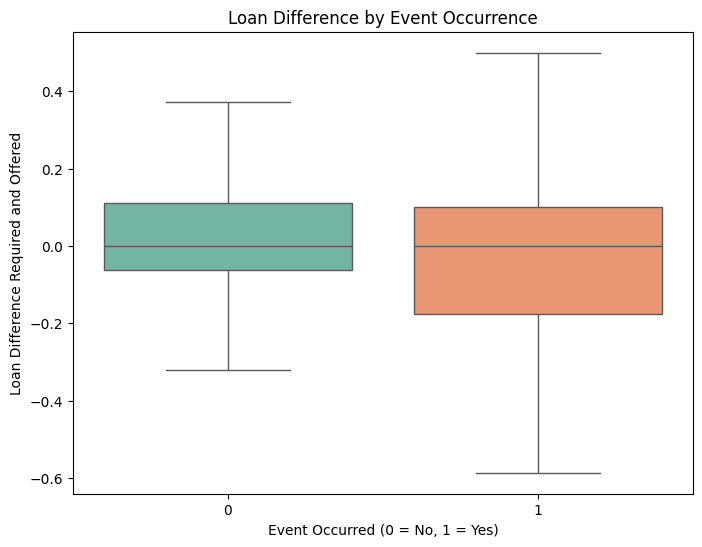

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_create_offer['event_of_interest_occured'] = df_create_offer['event_of_interest_occured'].astype('category')

plt.figure(figsize=(8, 6))
sns.boxplot(
    x='event_of_interest_occured', 
    y='loan_diff_req_and_off_perc', 
    data=df_create_offer, 
    palette="Set2",
    showfliers=False  # This line removes the outlier points
)
plt.title('Loan Difference by Event Occurrence')
plt.xlabel('Event Occurred (0 = No, 1 = Yes)')
plt.ylabel('Loan Difference Required and Offered')
plt.show()